In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
import os

In [2]:
twin_pairs_dfs = []

for file in os.listdir('../data/'):
    if 'twin_pairs' in file:
        df = pd.read_csv(f"../data/{file}")
        unwanted_columns = [col for col in df.columns if 'Unnamed' in col]
        df.drop(columns=unwanted_columns,inplace=True)
        twin_pairs_dfs.append(df)

df = pd.concat(twin_pairs_dfs, axis=1)


In [3]:
df.columns[df.isna().mean() == 0]

Index(['dbirwt_0', 'dbirwt_1', 'mort_0', 'mort_1', 'brstate', 'stoccfipb',
       'mager8', 'mrace', 'dmar', 'birmon', 'gestat10', 'csex', 'crace',
       'data_year', 'infant_id_0', 'infant_id_1', 'brstate_reg',
       'stoccfipb_reg'],
      dtype='object')

## messing around - part 1

In [4]:
# our motivation - we want to know if csex can help predict unhealthy weights
# we have to account for the fact that there's already a difference between birthweight between sexes
# y = weight difference between twins / combined weight / average weight
# y = combined weight of the twins/(avg(combined weight within the sex))
# for a perfectly average birthweight y = 1
# avg combined birthweight for boys is 2000g -> y = 1
# avg combined birthweight for girls is 1800g  -> y = 1
# a pair of boys is combined 2200/2000 = 1.1
# x = csex 1/0
# maybe one sex is more prone to extreme weight fluctuations from the average

In [5]:
# the average combined birthweight grouped by csex
# for each row, we combine birthweights and divide by the quantity above
df['combined_weight'] = df['dbirwt_0'] + df['dbirwt_1']
df['normed_avg'] = 0
df.loc[df['csex'] == 0,'normed_avg'] = df['combined_weight']/df.groupby('csex')['combined_weight'].mean()[0]
df.loc[df['csex'] == 1,'normed_avg'] = df['combined_weight']/df.groupby('csex')['combined_weight'].mean()[1]

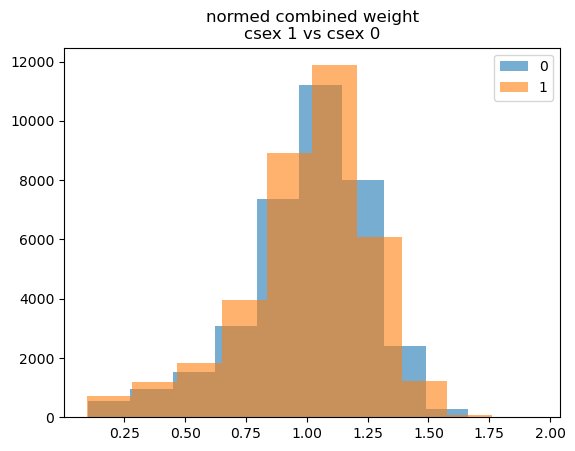

In [6]:
plt.figure()
plt.hist(df.loc[df['csex'] == 0,'normed_avg'],alpha=.6,label = "0")
plt.hist(df.loc[df['csex'] == 1,'normed_avg'],alpha=.6,label="1")
plt.title("normed combined weight\ncsex 1 vs csex 0")
plt.legend()
plt.show()

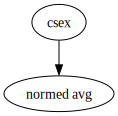

In [7]:
g = gr.Digraph()

g.edge("csex", "normed avg")

g

In [8]:
result = smf.ols('normed_avg ~ csex', data=df[['normed_avg','csex']]).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.0000,0.001,719.445,0.000,0.997,1.003
csex,-2.271e-15,0.002,-1.16e-12,1.000,-0.004,0.004


In [9]:
result.rsquared
# predicted normed_avg weight = regression formula = 1 - .000..0*csex{0,1}
# rsquared is a measure of the overall "quality" of the model - is it good is it bad
# "percentage of variance explained...how much of the variance in normed_avg is explained by csex"
# rsquared = 1 --> 100% of the variance in y is explained by x --> a perfect model y_predicted - y_actual is always 0
# rsquared = 0 --> 0% of the variance in y is explained by x --> if y_predicted = avg(y)

-2.220446049250313e-16

## reflection

the above regression actually doesn't make sense.

by normalizing the weight by sex, we are in effect accounting for the variation in weight due to sex. to then regress on sex is redundant, any additional variation will not be due to sex. 

In [10]:
# let's just straightforwardly model combined twin weight as a function of sex 
result = smf.ols('combined_weight ~ csex', data=df[['combined_weight','csex']]).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4736.4607,6.685,708.544,0.000,4723.359,4749.563
csex,137.7583,9.421,14.622,0.000,119.292,156.224


In [11]:
df.groupby('csex')['combined_weight'].mean() # compare this to the regression coefficients - notice anything??

csex
0    4736.460666
1    4874.218943
Name: combined_weight, dtype: float64

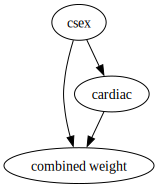

In [12]:
# again, we know we are naive about what causes what in biology
# we're just going to make up a theory
# the sex of the infant/fetus impacts the weight directly (this particular claim is pretty intuitive)
# and so does the cardiac risk of the mother (also not a head-scratching claim)
# but we also claim that sex influences cardiac risk - we have no idea if this is true.

df = df[~df['cardiac'].isna()]

g = gr.Digraph()

g.edge("csex", "combined weight")
g.edge("csex","cardiac")
g.edge("cardiac","combined weight")

g

In [13]:
result = smf.ols('combined_weight ~ csex + cardiac', data=df[['combined_weight','csex','cardiac']]).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4745.1990,6.873,690.448,0.000,4731.729,4758.669
csex,141.8813,9.673,14.667,0.000,122.922,160.841
cardiac,-155.3530,78.762,-1.972,0.049,-309.725,-0.980


In [14]:
def predicted_combined_weight(csex,cardiac):

    prediction = 4745.1990 + 141.8813*csex - 155.3530*cardiac

    return prediction

In [15]:
predicted_combined_weight(1,0), predicted_combined_weight(1,1)

(4887.0803, 4731.7273)

In [16]:
df.groupby(['csex','cardiac'])['combined_weight'].mean()

csex  cardiac
0     0.0        4745.113600
      1.0        4610.518248
1     0.0        4887.164390
      1.0        4707.521368
Name: combined_weight, dtype: float64

## messing around - part 2

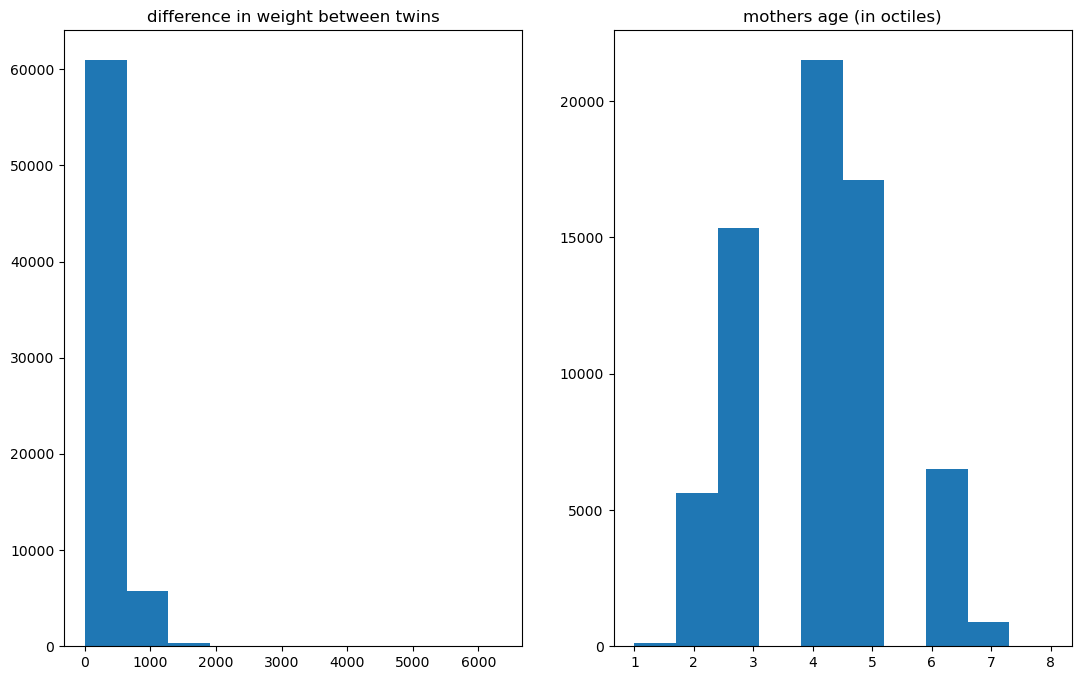

In [17]:
df['bw_difference'] =  df['dbirwt_1'] - df['dbirwt_0']

plt.subplots(1,2,figsize = (13,8))

plt.subplot(1,2,1)
plt.hist(df['bw_difference'])
plt.title("difference in weight between twins")

plt.subplot(1,2,2)
plt.hist(df['mager8'])
plt.title("mothers age (in octiles)")

plt.show()

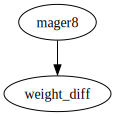

In [18]:
g = gr.Digraph()

g.edge("mager8", "weight_diff")

g

In [19]:
result = smf.ols('bw_difference ~ mager8', data=df[['bw_difference','mager8']]).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,235.0297,3.576,65.717,0.000,228.020,242.039
mager8,12.0681,0.842,14.339,0.000,10.419,13.718
